In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Reading other group's dataset

In [35]:
df = pd.read_csv('../data/data.csv', sep=';')
df.head(2)

,id,name,nutriscore,energy,fat_g,sugar_g,sodium_mg,perc_fruit,fibers_g,proteins_g
0,3168930010265,Cruesli Mélange De Noix,a,1933.008,19.0,12.0,0.0,0.0,10.0,8.5
1,80135463,NaN,e,2255.176,30.9,56.3,42.8,0.0,0.0,6.3


In [36]:
# ignoring the beverages / non-solid foods
filter_words = ['beverages', 'dairy', 'sauces']
refined_df = df[~df['name'].str.contains('|'.join(filter_words), case=False, na=False)]
# refined_df.to_csv('../data/other_group_v2.csv', index = False)

### Preprocessing on their data

In [37]:
def get_points(bounds, value, fruit_flag=False):
    if fruit_flag:
        if value > 80:
            return 5
    for i in range(len(bounds) - 1):
        if bounds[i] < value <= bounds[i + 1]:
            return i
    return len(bounds) - 1 if value > bounds[-1] else 0

In [38]:
def CalculatePoints(product):
    '''
    Define the bounds for each of the four categories for negative nutrients and positive nutrients
    '''
    # negative nutrients: energy, sugar, sodium, saturated fatty acid
    energy_bounds = [0, 335, 670, 1005, 1340, 1675, 2010, 2345, 2680, 3015, 3350]
    sugars_bounds = [0, 4.5, 9, 13.5, 18, 22.5, 27, 31.5, 36, 40.5, 45]
    sodium_bounds = [0, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900]
    saturated_fatty_acid_bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    # positive nutrients: fruit, fiber, protein
    fruit_bounds = [0, 40, 60, 80, 100]
    fiber_bounds = [0, 0.9, 1.9, 2.8, 3.7, 4.7]
    proteins_bounds = [0, 1.6, 3.2, 4.8, 6.4, 8.0]

    # Find the points for each of the four categories for negative nutrients
    energy_points = get_points(energy_bounds, product['energy'])
    sugars_points = get_points(sugars_bounds, product['sugar_g'])
    sodium_points = get_points(sodium_bounds, product['sodium_mg'])
    saturated_fatty_acid_points = get_points(saturated_fatty_acid_bounds, product['fat_g'])

    # find the points for the positive nutrients
    fruit_points = get_points(fruit_bounds, product['perc_fruit'], fruit_flag=True)
    fiber_points = get_points(fiber_bounds, product['fibers_g'])
    protein_points = get_points(proteins_bounds, product['proteins_g'])

    # append the points to the dataframe
    product['energy_points'] = energy_points
    product['sugars_points'] = sugars_points
    product['sodium_points'] = sodium_points
    product['saturated_fat_points'] = saturated_fatty_acid_points
    product['fruit_points'] = fruit_points
    product['fiber_points'] = fiber_points
    product['proteins_points'] = protein_points

    return product

In [39]:
# Obtaining the points
# t1 = pd.read_csv('../data/other_group_v2.csv')
t2 = refined_df.apply(CalculatePoints, axis = 1)

t2 = t2.drop_duplicates()
t2 = t2.dropna(how = 'any')
t2.to_csv('../data/other_group_preprocessed_points.csv', index = False)

### Defining additive model 

In [40]:
en = "energy_points"
su = "sugars_points"
fa = "saturated_fat_points"
sa = "sodium_points"
pr = "proteins_points"
fi = "fiber_points"
fr = "fruit_points"

criteria_to_minimize = {en, su, fa, sa}
criteria_to_maximize = {pr, fi, fr}

In [41]:
# Additive model 
def new_scale_transform(df):
    """
    Defines a new transformed scale for each criterion:
    1. x'_i = 10 - x_i for the criteria to be minimized i ∈ {en, su, fa, sa}
    2. x'_i = 2 * x_i for the criteria to be maximized i ∈ {pr, fi, fr}
    """
    for column in df.columns:
        if column in criteria_to_minimize:
            df[column] = 10 - df[column]
        elif column in criteria_to_maximize:
            df[column] = 2 * df[column]
    return df

In [42]:
def our_model(df):
    # 40 − F(x) = 40 - F(x'_en, x'_su, x'_fa, x'_sa, x'_pr, x'_fi, x'_fr) = 40 - x'_en + x'_su + x'_fa + x'_sa + 1/2(x'_pr + x'_fi) + x'fr
    return 15.75 - (0.5*df[en] + 0.1*df[su] + 0.4*df[fa] + 0.35*df[sa] + 0.2*df[pr] + 0.3*df[fi] - 0.05*df[fr])

In [43]:
def normal_model_labels(df):
    score = df['our_nutrition_score']
    return np.where(score < 0, 'a',
                    np.where(score <= 1 , 'b',
                                np.where(score < 11/ 3.075, 'c',
                                        np.where(score < 19/ 3.075, 'd',
                                                np.where(score <= 40/ 3.075, 'e', 'ERROR')))))

### Running additive model on their data

In [44]:
df = pd.read_csv('../data/other_group_preprocessed_points.csv')

In [45]:
df = new_scale_transform(df)
df.head(2)

,id,name,nutriscore,energy,fat_g,sugar_g,sodium_mg,perc_fruit,fibers_g,proteins_g,energy_points,sugars_points,sodium_points,saturated_fat_points,fruit_points,fiber_points,proteins_points
0,3168930010265,Cruesli Mélange De Noix,a,1933.008,19.0,12.0,0.0,0.0,10.0,8.5,5,8,10,0,0,10,10
1,20267605,Anacardi,b,2510.400,47.6,6.5,8.0,0.0,5.2,20.5,3,9,10,0,0,10,10


In [46]:
# calculate score using normal model
df['our_nutrition_score'] = our_model(df)

# assign label for normal model
df['our_nutrition_label'] = normal_model_labels(df)

### Evaluating their original nutrition score vs generated from our additive model

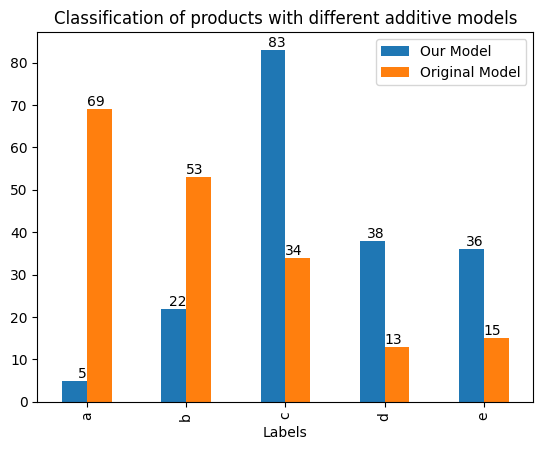

In [47]:
compare = pd.DataFrame(df['our_nutrition_label'].value_counts())
compare['our_nutrition_label'] = pd.DataFrame(df['our_nutrition_label'].value_counts())
compare['original_label'] = df['nutriscore'].value_counts()
compare['Labels'] = compare.index
compare.sort_index(inplace = True)

fig, ax = plt.subplots()
compare.plot(x = 'Labels', y = ['our_nutrition_label', 'original_label'], kind="bar", ax=ax, title="Classification of products with different additive models")
ax.legend(["Our Model","Original Model"])

for i, val in enumerate(compare['our_nutrition_label']):
    ax.text(i, val, str(val), ha='right', va='bottom')

for i, val in enumerate(compare['original_label']):
    ax.text(i, val, str(val), ha='left', va='bottom')

plt.show()

Confusion Matrix:
Predicted  a   b   c   d   e
Actual                      
a          5  20  38   6   0
b          0   1  34  15   3
c          0   1   7  10  16
d          0   0   1   4   8
e          0   0   3   3   9


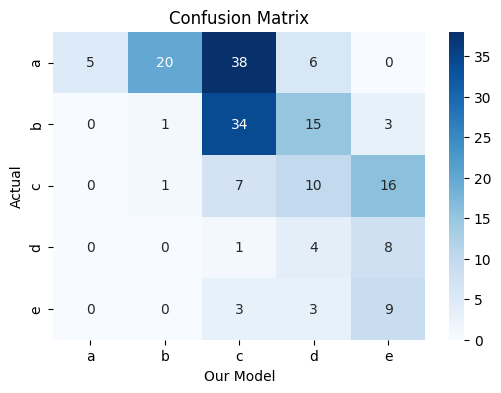

In [61]:
# Create a confusion matrix using crosstab
confusion_matrix = pd.crosstab(df['nutriscore'], df['our_nutrition_label'], rownames=['Actual'], colnames=['Predicted'])

print("Confusion Matrix:")
print(confusion_matrix)
# Plotting the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Our Model')
plt.ylabel('Actual')
plt.show()

Confusion Matrix:
Predicted   a   b   c   d   e
Actual                       
a          69   0   0   0   0
b           0  53   0   0   0
c           0   0  34   0   0
d           0   0   0  13   0
e           0   0   0   0  15


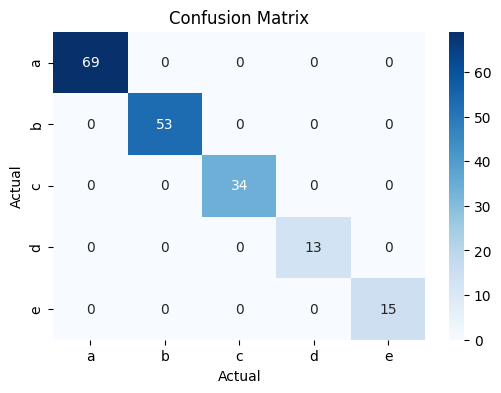

In [62]:
# Create a confusion matrix using crosstab
confusion_matrix = pd.crosstab(df['nutriscore'], df['nutriscore'], rownames=['Actual'], colnames=['Predicted'])

print("Confusion Matrix:")
print(confusion_matrix)
# Plotting the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Actual')
plt.show()

In [49]:
# read thier scores
others_scores = pd.read_csv('../data/nutri_scores.csv')
others_scores.head(2)

,nutriscore,G_0,PMS_0.5,PMS_0.6,PMS_0.7,OMS_0.5,OMS_0.6,OMS_0.7,Decision Tree,kNN,Random Forest
0,a,b,a,a,a,c,e,e,a,a,a
1,e,e,b,e,e,e,e,e,e,e,e


In [50]:
# merge the df with the others_scores based on index of the rows
merged_df = df.merge(others_scores, left_index=True, right_index=True)

In [51]:
merged_df.columns

Index(['id', 'name', 'nutriscore_x', 'energy', 'fat_g', 'sugar_g', 'sodium_mg',
       'perc_fruit', 'fibers_g', 'proteins_g', 'energy_points',
       'sugars_points', 'sodium_points', 'saturated_fat_points',
       'fruit_points', 'fiber_points', 'proteins_points',
       'our_nutrition_score', 'our_nutrition_label', 'nutriscore_y', 'G_0',
       'PMS_0.5', 'PMS_0.6', 'PMS_0.7', 'OMS_0.5', 'OMS_0.6', 'OMS_0.7',
       'Decision Tree', 'kNN', 'Random Forest'],
      dtype='object')

In [52]:
merged_df.head(2)

,id,name,nutriscore_x,energy,fat_g,sugar_g,sodium_mg,perc_fruit,fibers_g,proteins_g,...,G_0,PMS_0.5,PMS_0.6,PMS_0.7,OMS_0.5,OMS_0.6,OMS_0.7,Decision Tree,kNN,Random Forest
0,3168930010265,Cruesli Mélange De Noix,a,1933.008,19.0,12.0,0.0,0.0,10.0,8.5,...,b,a,a,a,c,e,e,a,a,a
1,20267605,Anacardi,b,2510.400,47.6,6.5,8.0,0.0,5.2,20.5,...,e,b,e,e,e,e,e,e,e,e


Confusion Matrix:
Predicted  a   b   c   d   e
Actual                      
a          0   0   0   1   1
b          2  11  30  14  10
c          3   7  45  18  18
d          0   3   4   4   4
e          0   1   4   1   3


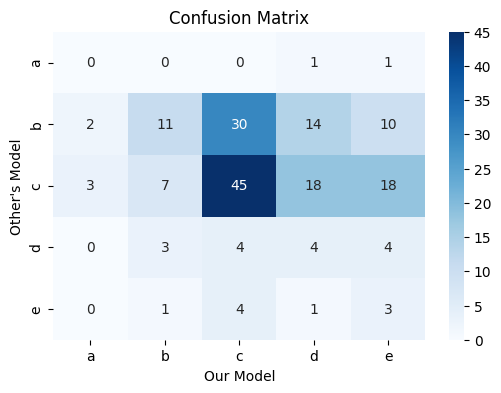

In [53]:
# Create a confusion matrix using crosstab
confusion_matrix_others = pd.crosstab(merged_df['G_0'], merged_df['our_nutrition_label'], rownames=['Actual'], colnames=['Predicted'])

print("Confusion Matrix:")
print(confusion_matrix_others)
# Plotting the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_others, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Our Model')
plt.ylabel('Other\'s Model')
plt.show()

Other's Confusion Matrix:
Predicted   a   b   c  d  e
Actual                     
a           0   0   1  1  0
b          32  20   8  3  4
c          29  27  20  6  9
d           4   4   3  2  2
e           4   2   2  1  0


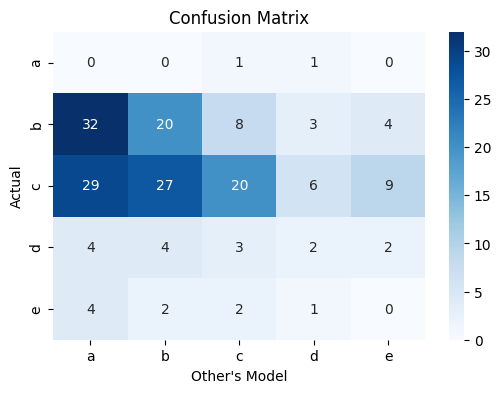

In [60]:
# Create a confusion matrix using crosstab
confusion_matrix_others = pd.crosstab(merged_df['G_0'], merged_df['nutriscore_x'], rownames=['Actual'], colnames=['Predicted'])

print("Other's Confusion Matrix:")
print(confusion_matrix_others)
# Plotting the confusion matrix as a heatmap using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_others, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Other\'s Model')
plt.ylabel('Actual')
plt.show()

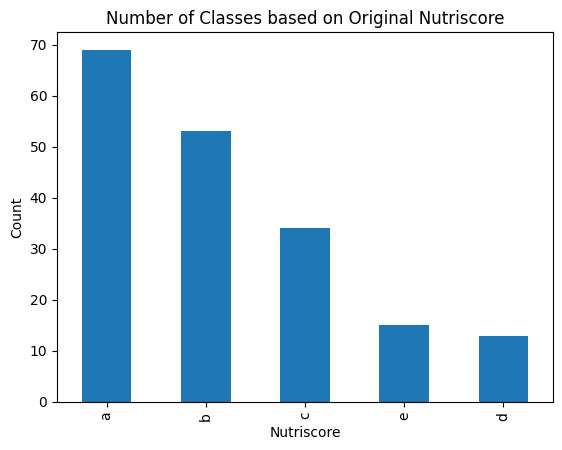

In [58]:
merged_df['nutriscore_x'].value_counts().plot(kind='bar')
plt.xlabel('Nutriscore')
plt.ylabel('Count')
plt.title('Number of Classes based on Original Nutriscore')
plt.show()
